C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


<IPython.core.display.Javascript object>


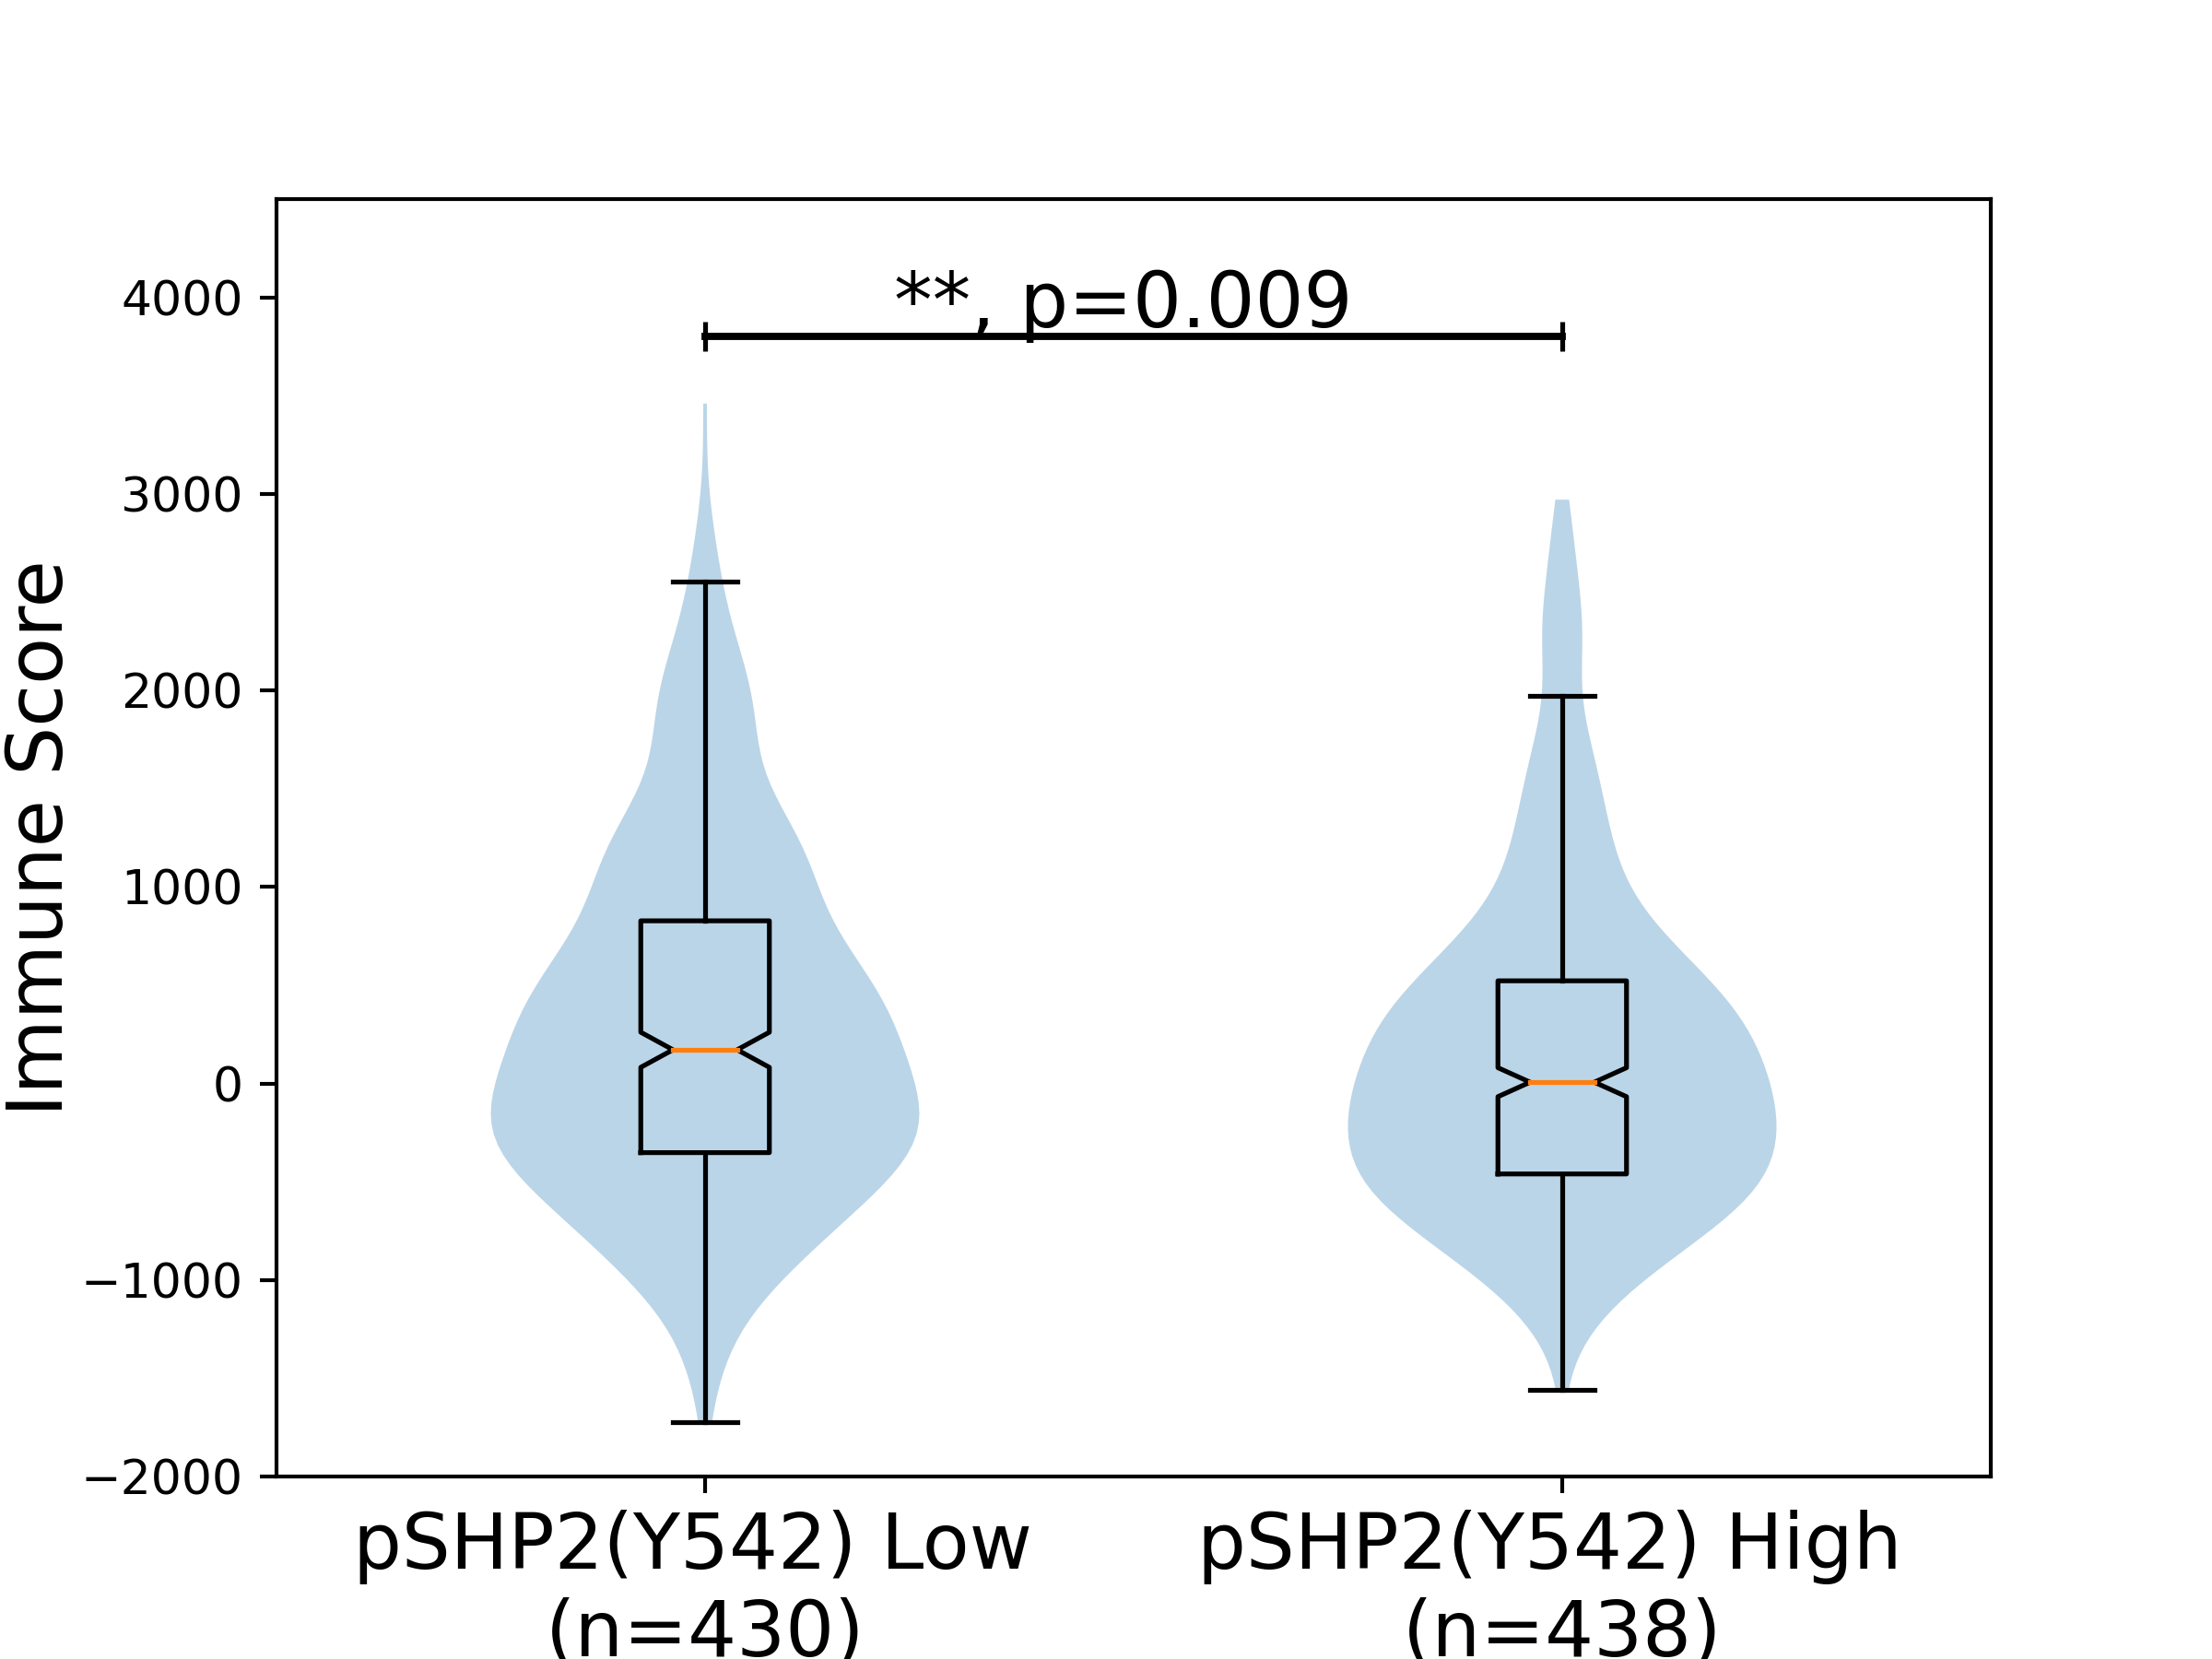

Text(0, 0.5, 'Immune Score')

In [21]:
# import all the packages used in this study
%matplotlib notebook
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
mpl.get_backend()
import matplotlib.pyplot as plt
import re

# import the raw datasets stored in local folders
df_clinic=pd.read_csv("Clinical_raw.csv", dtype=str).transpose()
df_score=pd.read_csv("immune score_raw.csv",dtype=str).dropna()
df_RPPA=pd.read_csv("RPPA_raw.csv",dtype=str).dropna().transpose()

# reset the header of each raw_datasets
df_clinic.columns=df_clinic.iloc[0]
df_clinic=df_clinic.drop("admin.batch_number", axis=0)

df_score["ID"]=[x.lower() for x in df_score["ID"]]
df_score=df_score.set_index("ID")

df_RPPA.columns=df_RPPA.iloc[0]
df_RPPA=df_RPPA.drop("Composite.Element.REF",axis=0).reset_index()
df_RPPA=df_RPPA.rename({"index":"Composite.Element.REF"}, axis="columns")
df_RPPA["Composite.Element.REF"]=[x.lower() for x in df_RPPA["Composite.Element.REF"]]
df_RPPA=df_RPPA.set_index("Composite.Element.REF")

# select some columns interested in clinics data
col=["patient.samples.sample.portions.portion.analytes.analyte-2.aliquots.aliquot-2.bcr_aliquot_barcode", 
     "patient.samples.sample.portions.shipment_portion.shipment_portion_bcr_aliquot_barcode", "patient.samples.sample.bcr_sample_barcode"]
df_clinic_sub=df_clinic[col]

# Rename the columns to fit the mRNA and RPPA datasets
df_clinic_sub=df_clinic_sub.rename({"patient.samples.sample.portions.portion.analytes.analyte-2.aliquots.aliquot-2.bcr_aliquot_barcode":
                                   "Hybridization REF","patient.samples.sample.portions.shipment_portion.shipment_portion_bcr_aliquot_barcode":
                                   "Composite.Element.REF","patient.samples.sample.bcr_sample_barcode":"ID"}, axis="columns")
df_clinic_sub=df_clinic_sub.set_index("Composite.Element.REF")
df_clinic_sub["ID"]=[x[0:15] for x in df_clinic_sub["ID"]]

# Merge the RPPA and clinical datasets. 
df_merge=pd.merge(df_clinic_sub, df_RPPA, how="outer", on="Composite.Element.REF").dropna()
df_merge=df_merge.set_index("ID")
df_merge=pd.merge(df_merge, df_score, how="outer", on="ID").dropna()

# divide the merged RPPA-clinical data sets into two groups by the mean of p-SHP2
df_pSHP2=df_merge[["PTPN11|SHP-2_pY542","Stromal_score","Immune_score","ESTIMATE_score"]].astype(float)
div=np.nanmean(df_pSHP2["PTPN11|SHP-2_pY542"])
df_pSHP2_low=df_pSHP2.where(df_pSHP2["PTPN11|SHP-2_pY542"]<=div).dropna()
df_pSHP2_high=df_pSHP2.where(df_pSHP2["PTPN11|SHP-2_pY542"]>div).dropna()

# plot the viloin plot of immune scores in differential p-SHP2 patient groups. 
data_to_plot=[df_pSHP2_low["Immune_score"],df_pSHP2_high["Immune_score"]]
plt.figure(dpi=300)
plt.violinplot(data_to_plot,[1,2],showmeans=False, showextrema=False)
plt.boxplot(data_to_plot, notch=True, sym="",whis=1.5)
plt.plot([1,2],[3800,3800],"-|", color="black")
plt.ylim((-2000,4500))
plt.gca().annotate('**, p=0.009',
            xy=(1.5, 4000), xycoords='data',
            xytext=(0.36, 0.9), textcoords='axes fraction',fontsize=16)
#plt.gca().axes.get_xaxis().set_visible(False)
my_xticks = ['pSHP2(Y542) Low \n(n=430)',"pSHP2(Y542) High \n(n=438)"]
plt.xticks([1,2], my_xticks,fontsize=16)
plt.ylabel("Immune Score",labelpad=0.5,fontsize=16)

<IPython.core.display.Javascript object>


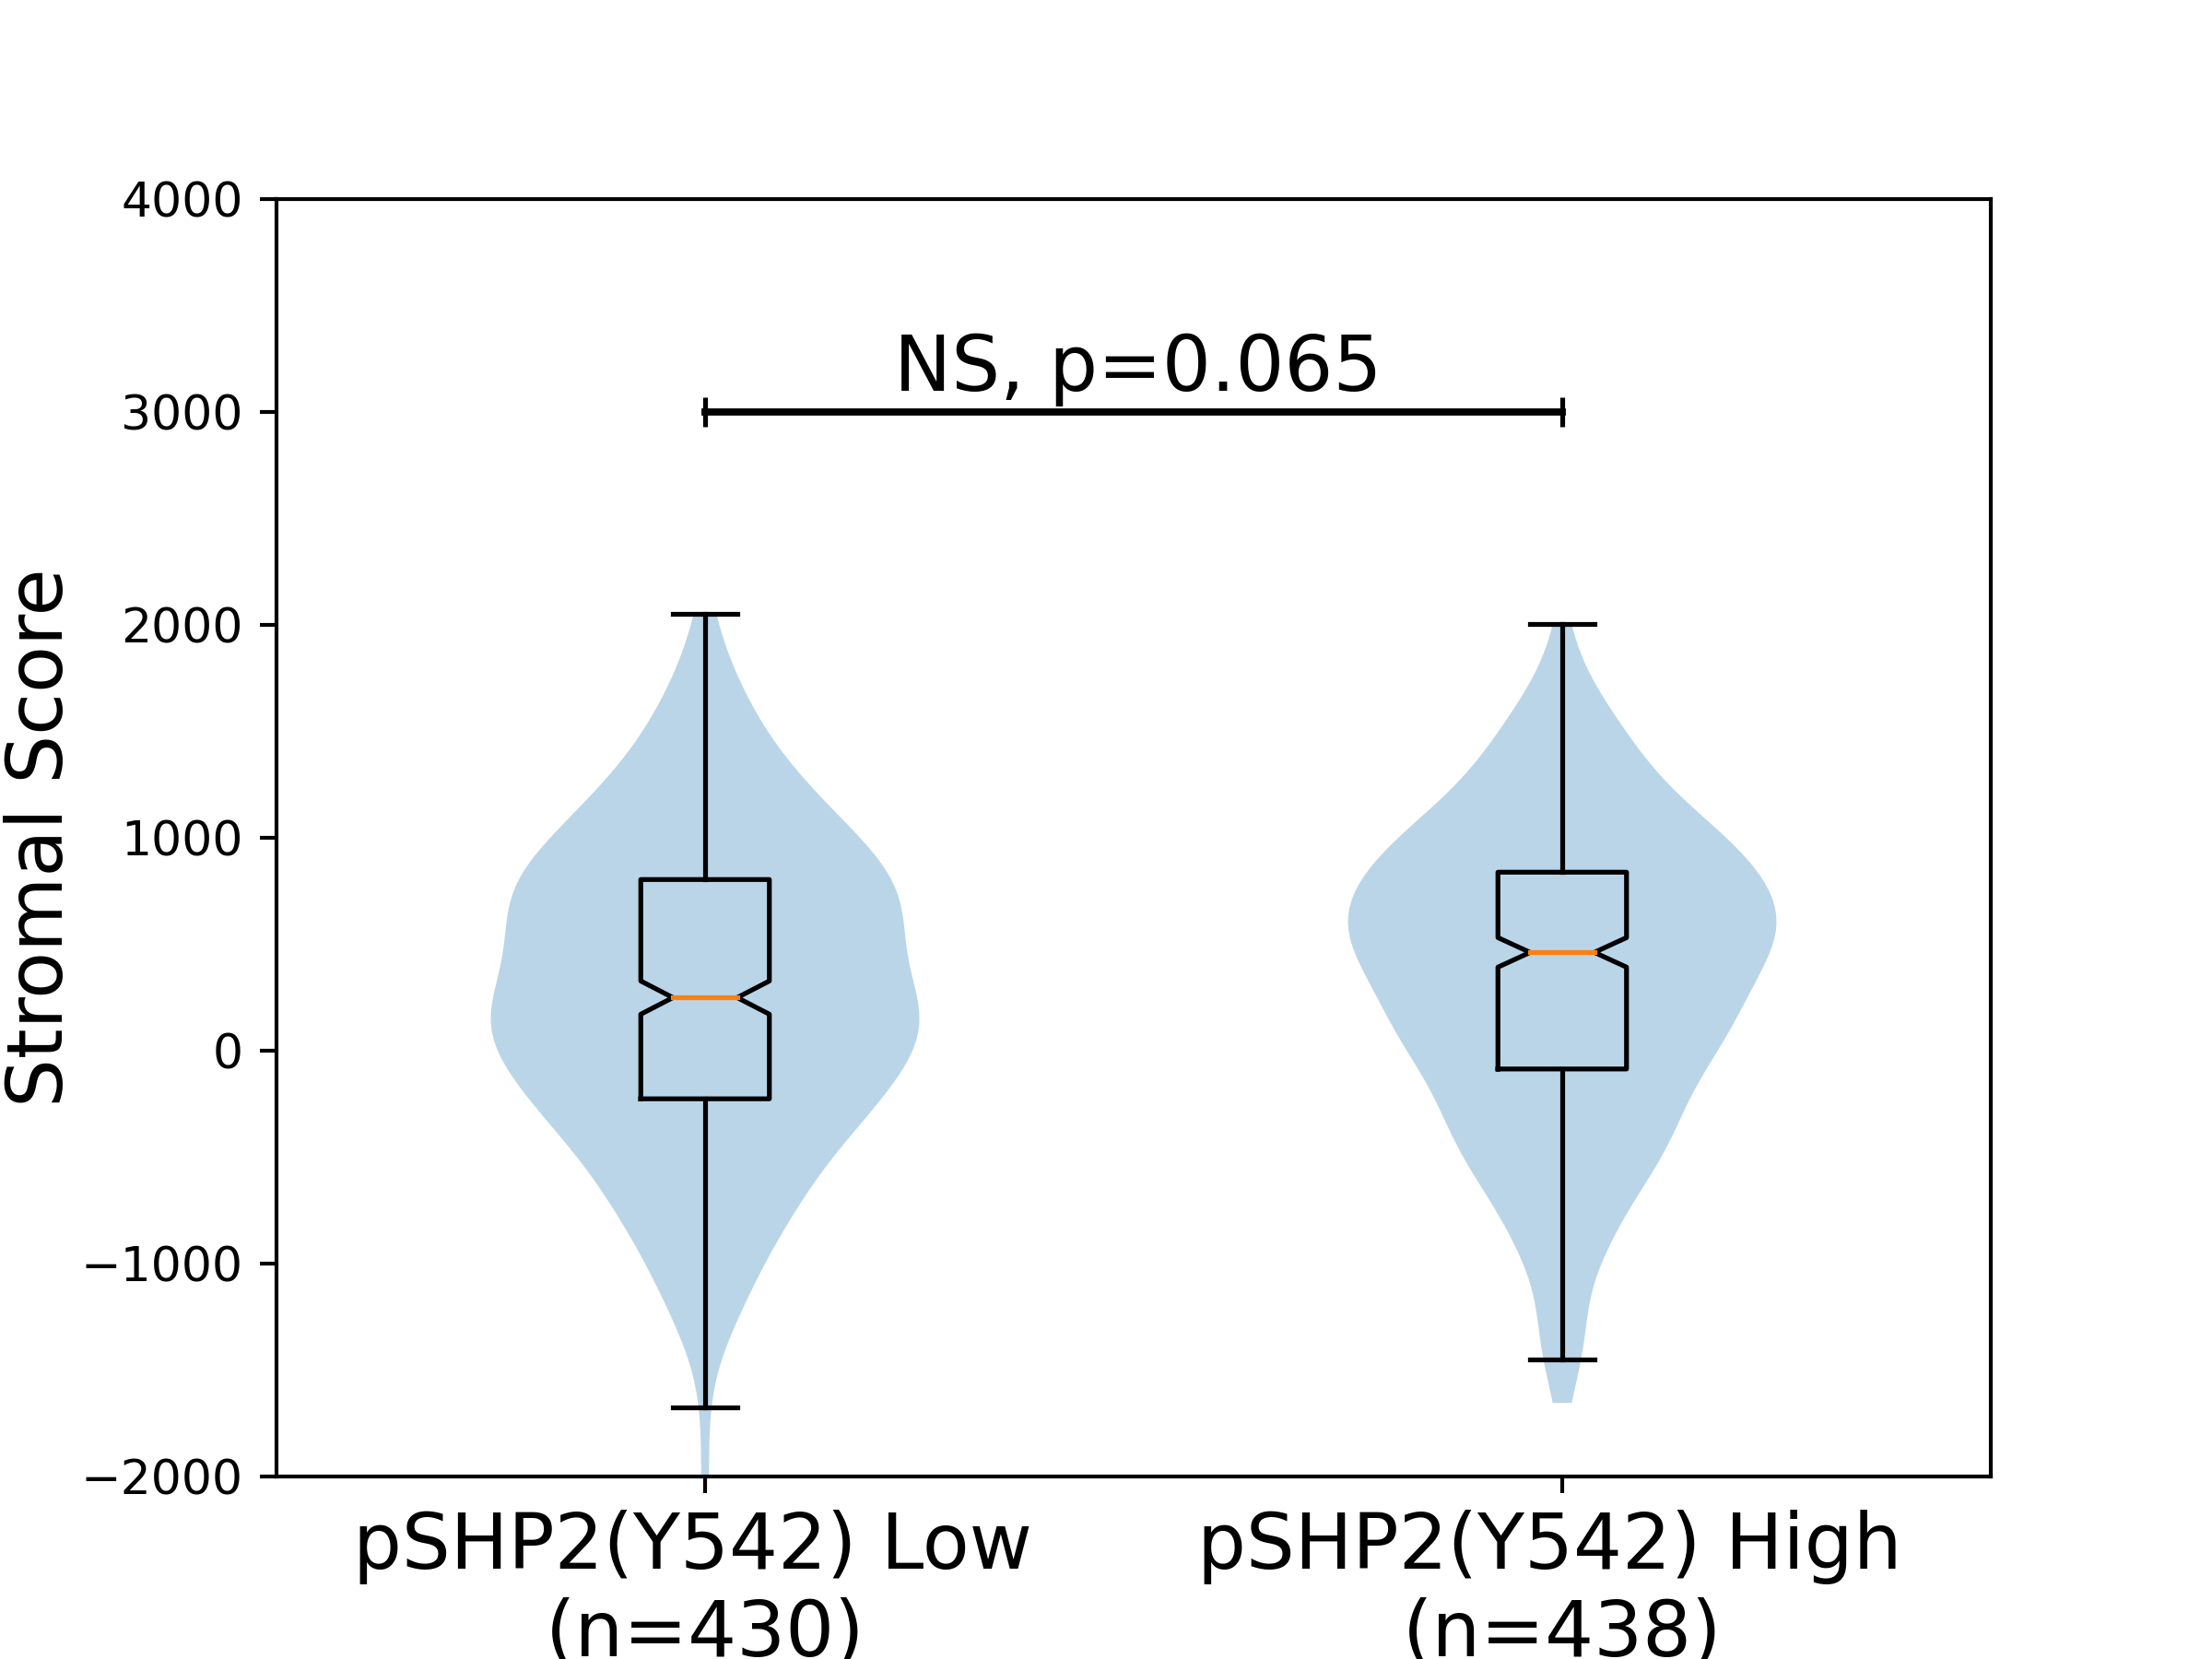

Text(0, 0.5, 'Stromal Score')

In [23]:
# plot the viloin plot of stroma scores in differential p-SHP2 patient groups. 
data_to_plot=[df_pSHP2_low["Stromal_score"],df_pSHP2_high["Stromal_score"]]
plt.figure(dpi=300)
plt.violinplot(data_to_plot,[1,2],showmeans=False, showextrema=False)
plt.boxplot(data_to_plot, notch=True, sym="",whis=1.5)
plt.plot([1,2],[3000,3000],"-|", color="black")
plt.ylim((-2000,4000))
plt.gca().annotate('NS, p=0.065',
            xy=(1.5, 4000), xycoords='data',
            xytext=(0.36, 0.85), textcoords='axes fraction',fontsize=16)
my_xticks = ['pSHP2(Y542) Low \n(n=430)',"pSHP2(Y542) High \n(n=438)"]
plt.xticks([1,2], my_xticks,fontsize=16)
plt.ylabel("Stromal Score",labelpad=0.5,fontsize=16)

In [24]:
# import the mRNA dataset, and process data cleaning 
df_mRNA=pd.read_csv("mRNA_raw.csv",dtype=str).dropna().transpose()
df_mRNA.columns=df_mRNA.iloc[0]
df_mRNA=df_mRNA.drop("Hybridization REF", axis=0).reset_index()
df_mRNA=df_mRNA.rename({"index":"ID"}, axis="columns")
df_mRNA["ID"]=[x.lower()[0:15] for x in df_mRNA["ID"]]
df_mRNA=df_mRNA.set_index("ID")
df_mRNA

# merge mRNA dataset with clinical datasets, and divide into two groups with mean of SHP2 
df_merge2=pd.merge(df_mRNA,df_score,how="outer",left_index=True, right_index=True).dropna()
df_SHP2=df_merge2[["PTPN11","Stromal_score","Immune_score","ESTIMATE_score"]].astype(float)
div=np.nanmedian(df_SHP2["PTPN11"])
df_SHP2_low=df_SHP2.where(df_SHP2["PTPN11"]<=div).dropna()
df_SHP2_high=df_SHP2.where(df_SHP2["PTPN11"]>div).dropna()


<IPython.core.display.Javascript object>


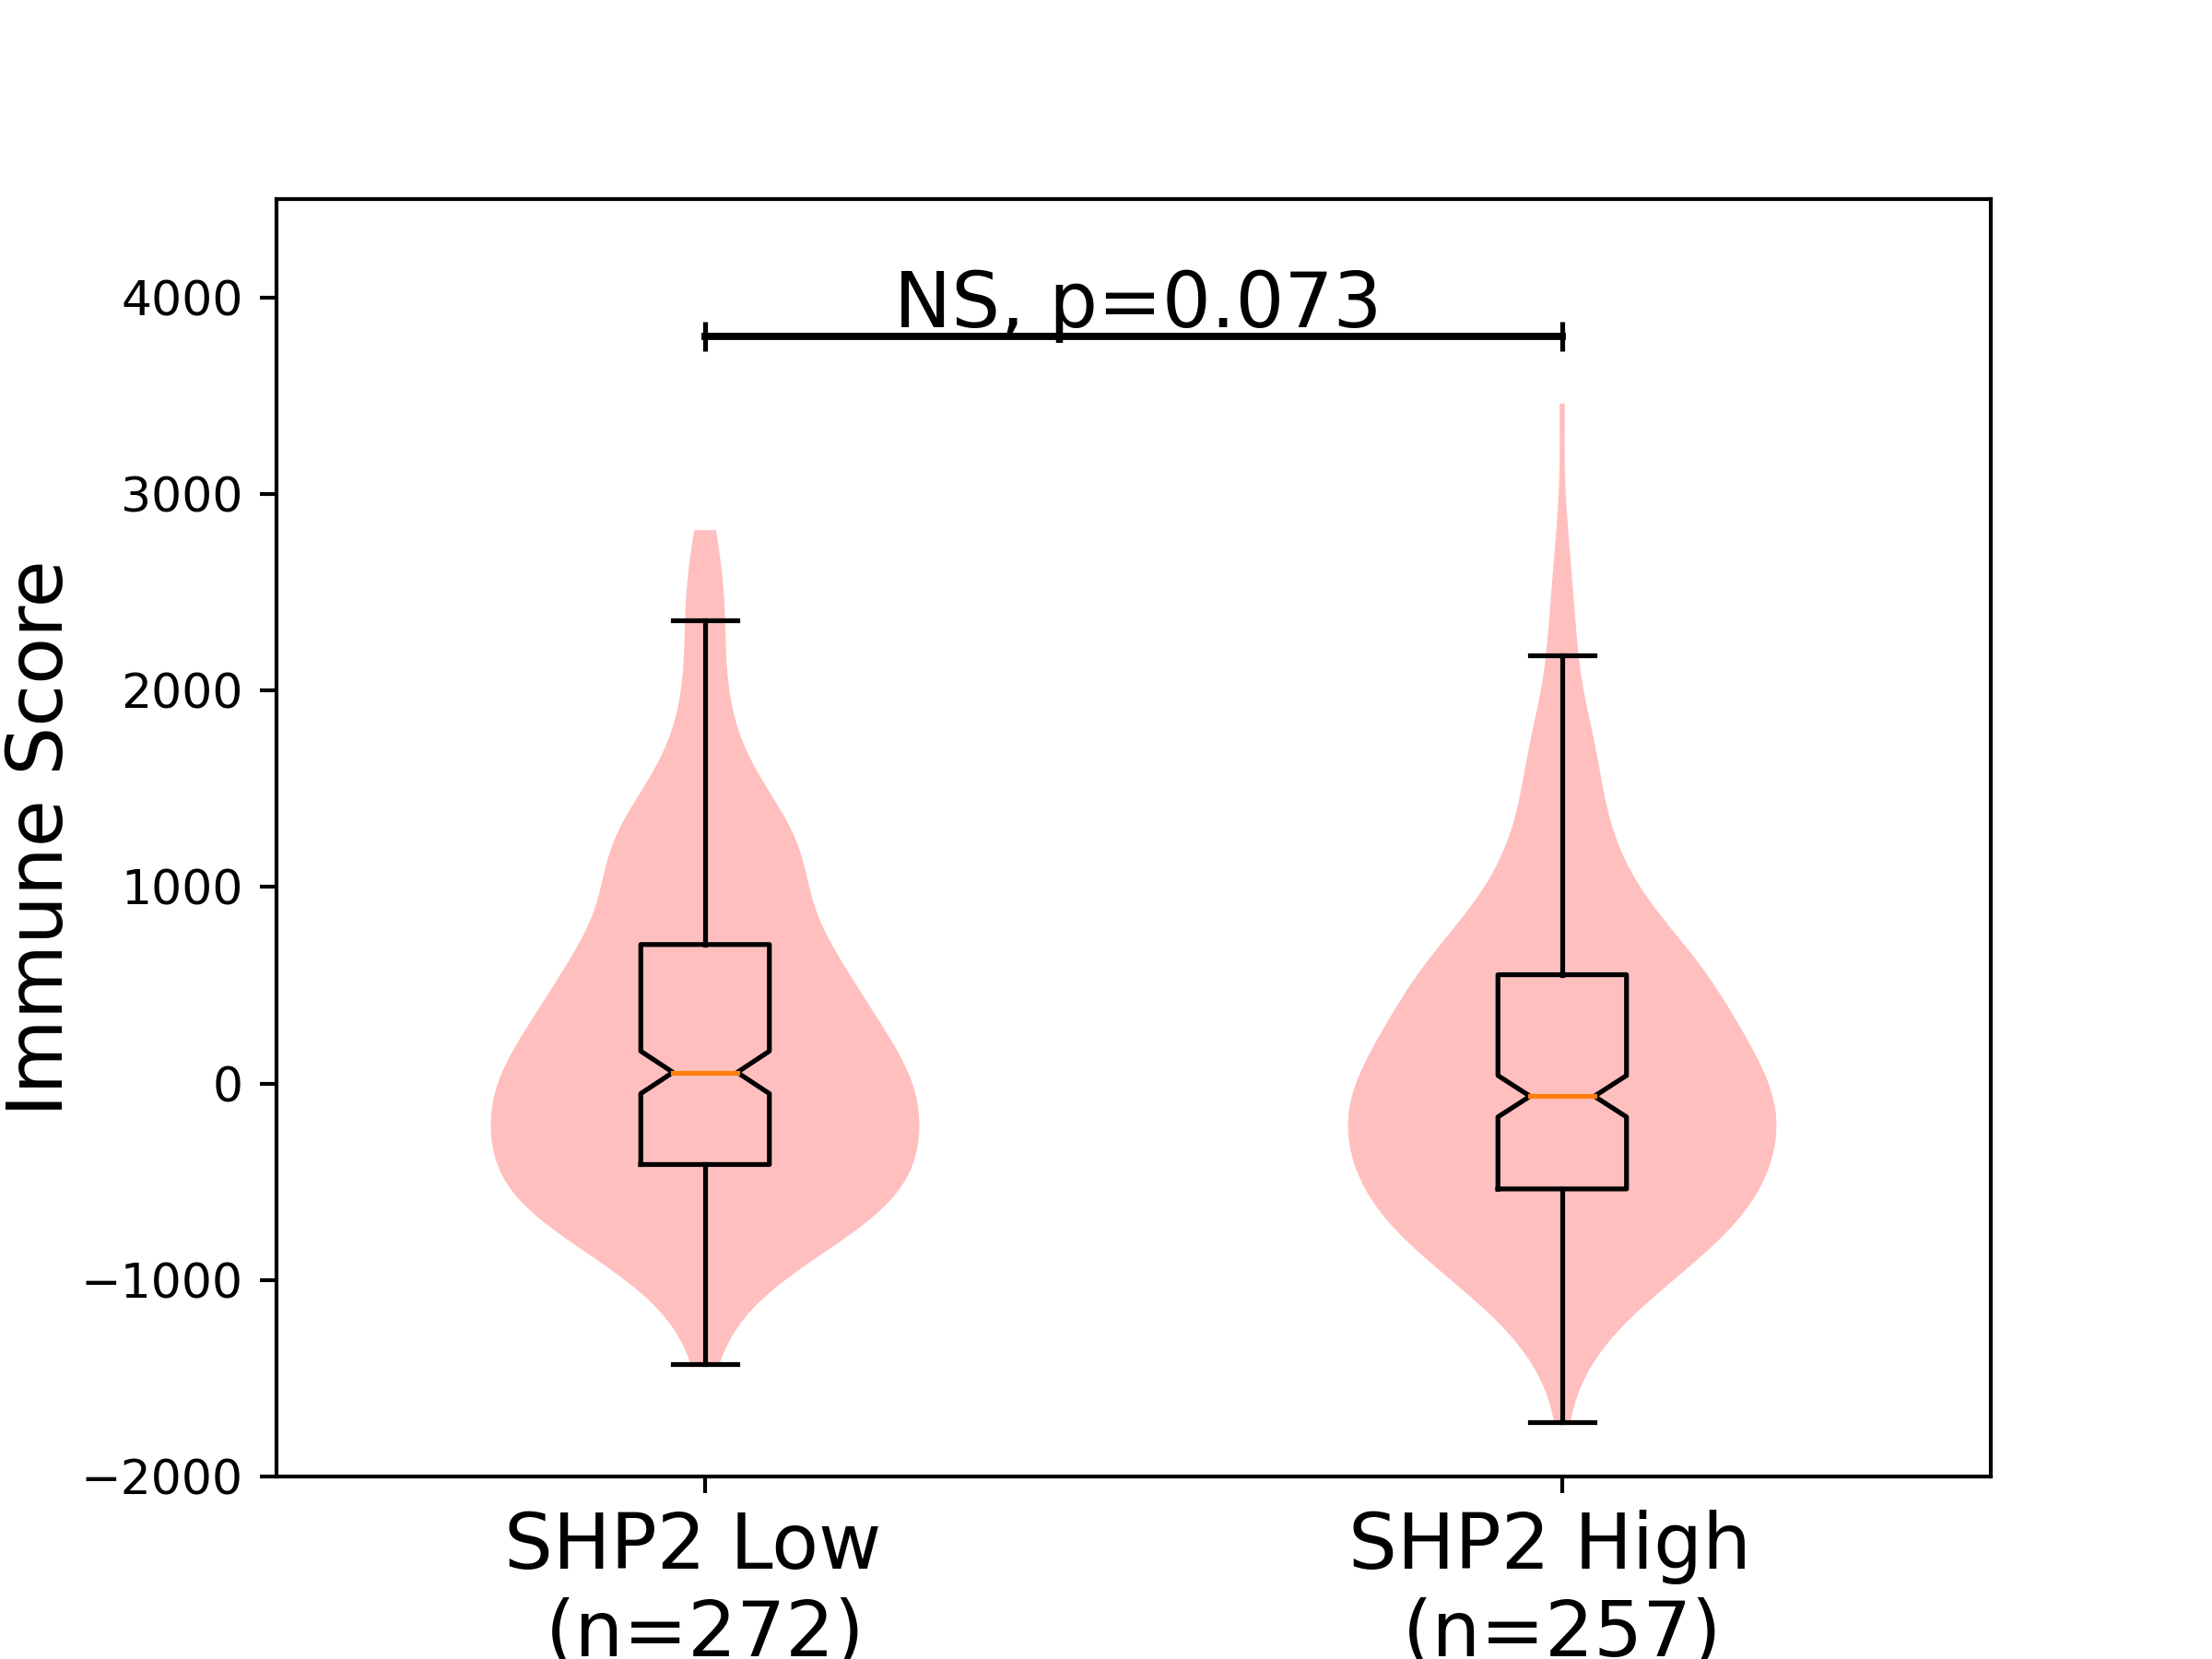

Text(0, 0.5, 'Immune Score')

In [25]:
# plot the viloin plot of immune scores in differential SHP2 patient groups. 
data_to_plot=[df_SHP2_low["Immune_score"],df_SHP2_high["Immune_score"]]
plt.figure(dpi=300)
fig=plt.violinplot(data_to_plot,[1,2],showmeans=False, showextrema=False)
for pc in fig['bodies']:
    pc.set_facecolor('red')
    pc.set_alpha(0.25)
plt.boxplot(data_to_plot, notch=True, sym="",whis=1.5)
plt.plot([1,2],[3800,3800],"-|", color="black")
plt.ylim((-2000,4500))
plt.gca().annotate('NS, p=0.073',
            xy=(1.5, 4000), xycoords='data',
            xytext=(0.36, 0.9), textcoords='axes fraction',fontsize=16)
#plt.gca().axes.get_xaxis().set_visible(False)
my_xticks = ['SHP2 Low \n(n=272)',"SHP2 High \n(n=257)"]
plt.xticks([1,2], my_xticks,fontsize=16)
plt.ylabel("Immune Score",labelpad=0.5,fontsize=16)

<IPython.core.display.Javascript object>


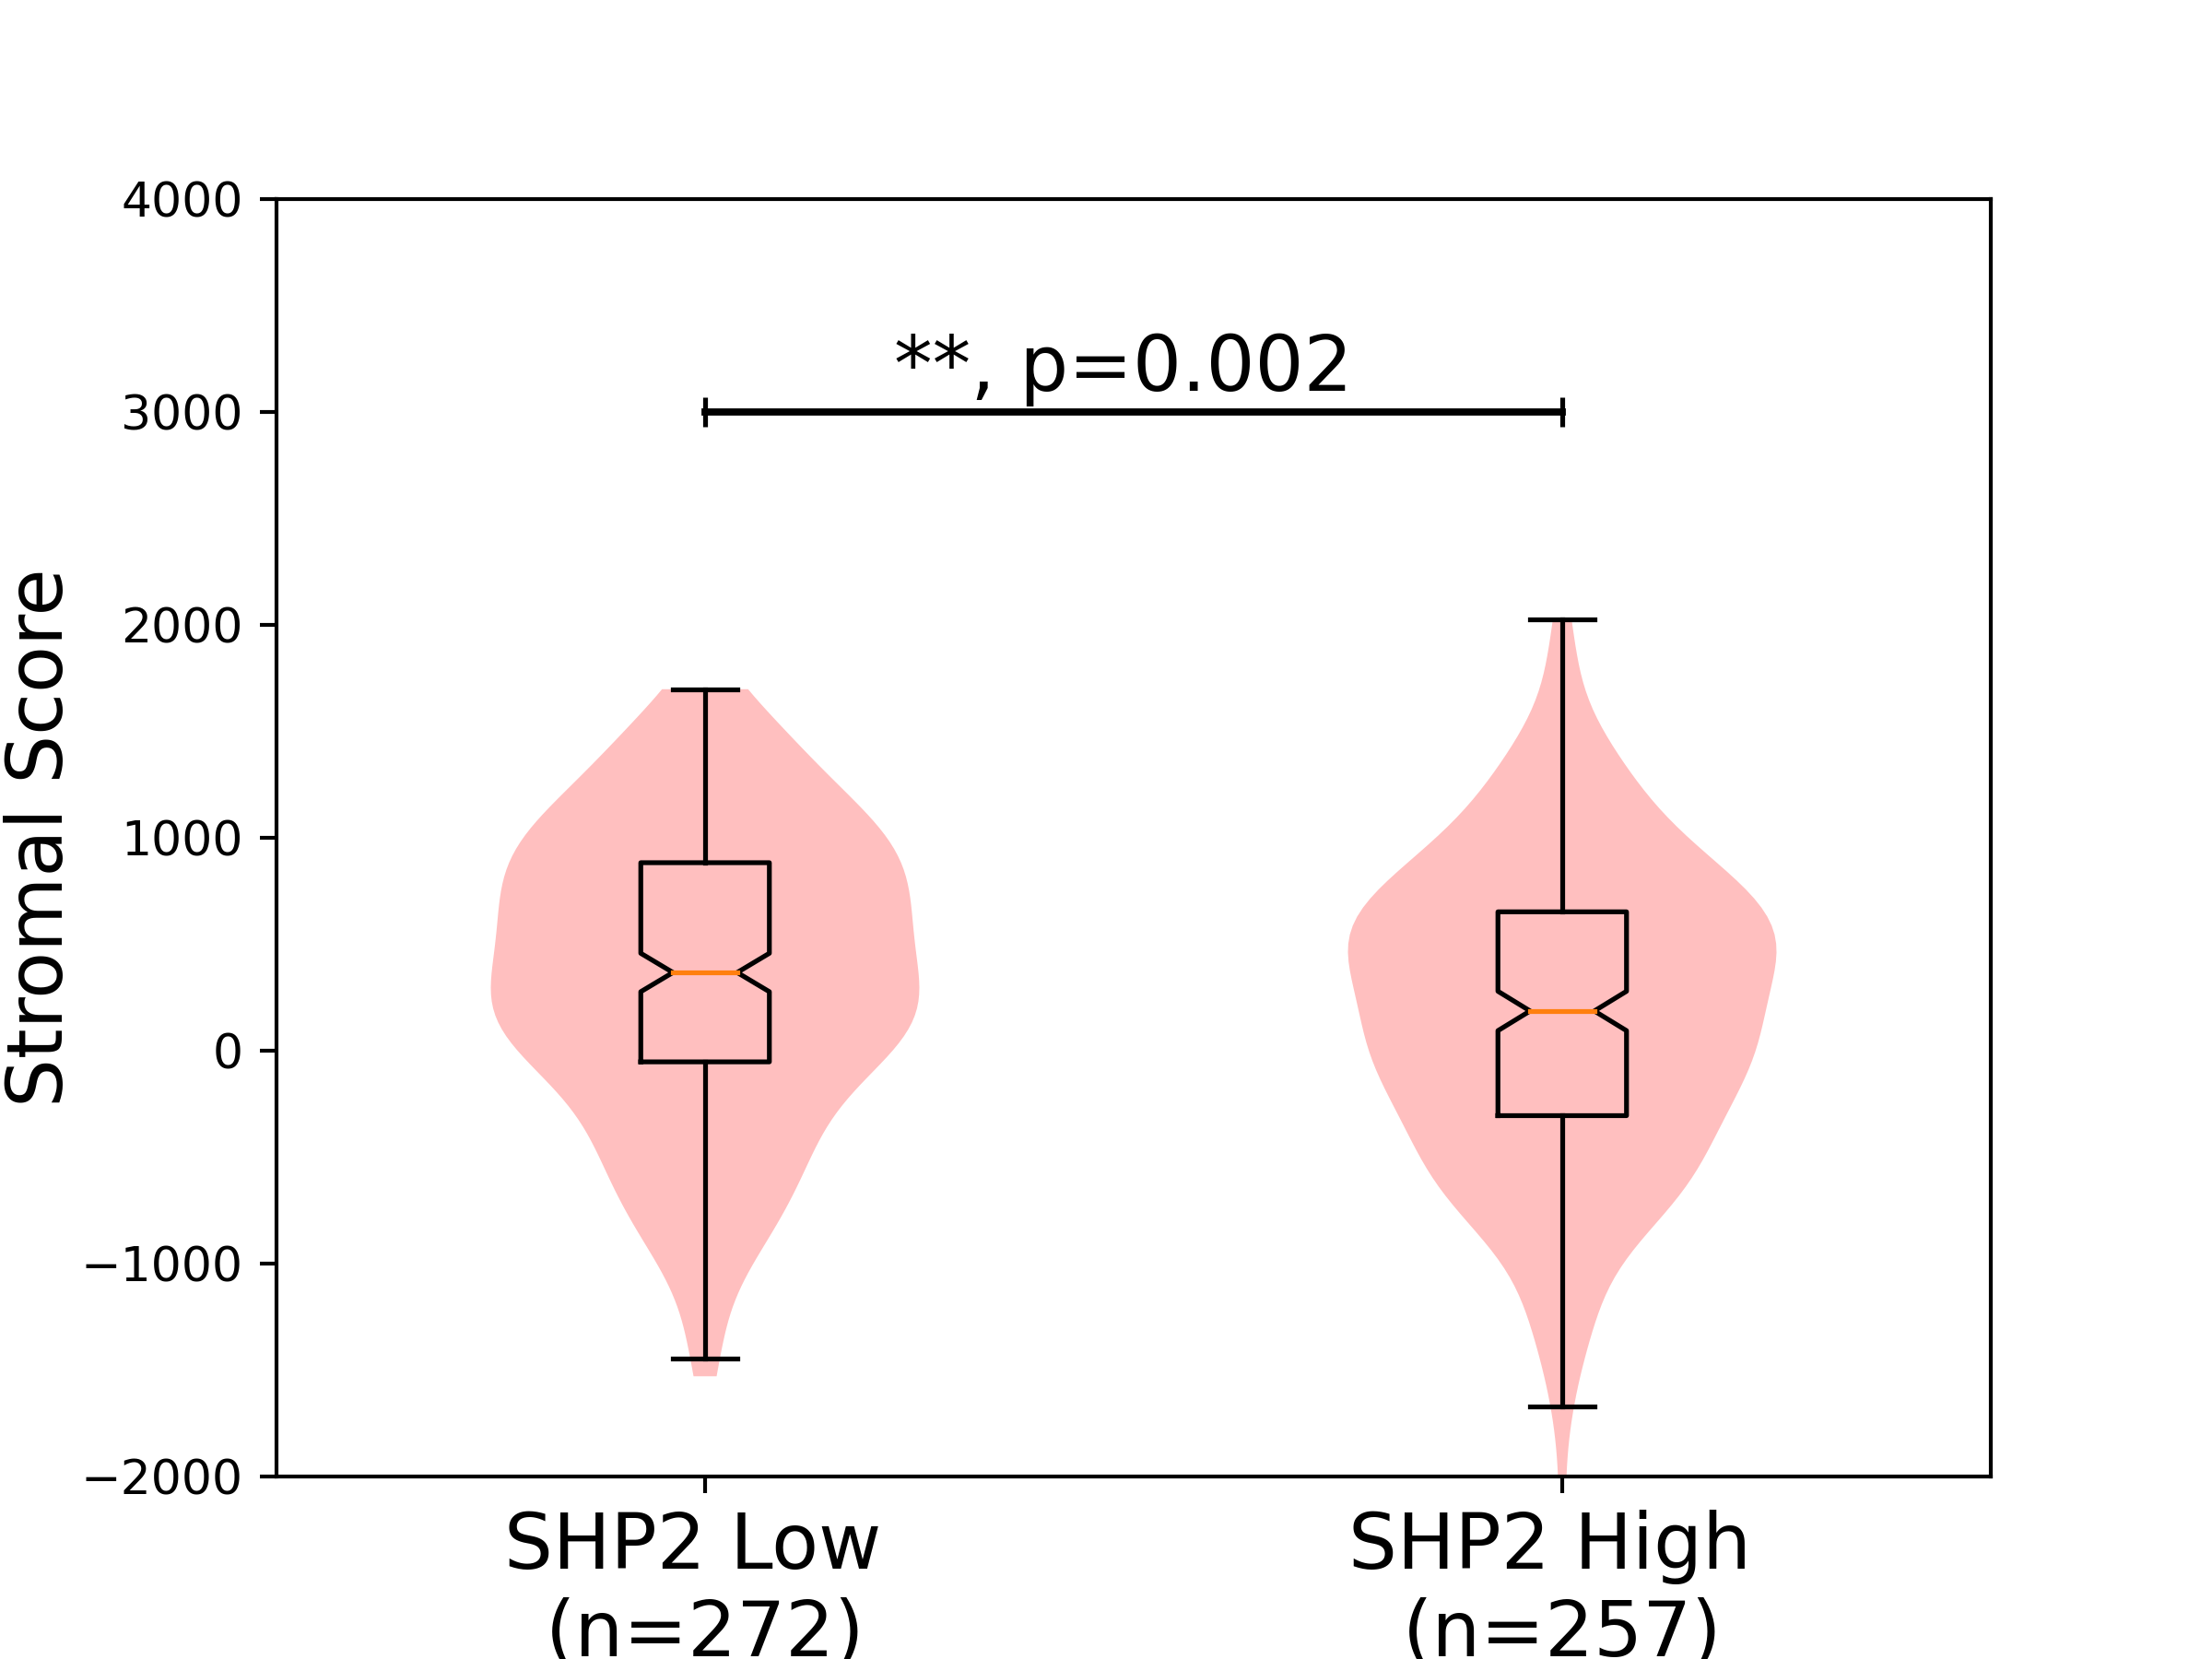

Text(0, 0.5, 'Stromal Score')

In [26]:
# plot the viloin plot of stroma scores in differential SHP2 patient groups. 
data_to_plot=[df_SHP2_low["Stromal_score"],df_SHP2_high["Stromal_score"]]
plt.figure(dpi=300)
fig=plt.violinplot(data_to_plot,[1,2],showmeans=False, showextrema=False)
for pc in fig['bodies']:
    pc.set_facecolor('red')
    pc.set_alpha(0.25)
plt.boxplot(data_to_plot, notch=True, sym="",whis=1.5)
plt.plot([1,2],[3000,3000],"-|", color="black")
plt.ylim((-2000,4000))
plt.gca().annotate('**, p=0.002',
            xy=(1.5, 4000), xycoords='data',
            xytext=(0.36, 0.85), textcoords='axes fraction',fontsize=16)
#plt.gca().axes.get_xaxis().set_visible(False)
my_xticks = ['SHP2 Low \n(n=272)',"SHP2 High \n(n=257)"]
plt.xticks([1,2], my_xticks,fontsize=16)
plt.ylabel("Stromal Score",labelpad=0.5,fontsize=16)